In [3]:
%matplotlib inline

In [4]:
from keras.models import Model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D, Conv2D
from keras import optimizers
import numpy as np
import h5py
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import copy
import pdb

/home/ubuntu/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import cv2

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
input_shape = (224, 224, 3) # Chosen so that task 2 will be easier
train = 'data/train/'
test = 'data/test/'
max_numbers = 6
number_of_classes = 10
box_keys = 4
train_size = 33402
test_size = 13068

## Unpack image y-data (run only first time)

In [6]:
def get_box_data(index, hdf5_data):
    """
    get `left, top, width, height` of each picture
    :param index:
    :param hdf5_data:
    :return:
    """
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(hdf5_data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = hdf5_data['/digitStruct/bbox'][index]
    hdf5_data[box[0]].visititems(print_attrs)
    return meta_data

def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])

In [14]:
train_mat_data = h5py.File(train + 'digitStruct.mat', 'r') 
train_size = train_mat_data['/digitStruct/name'].size
train_size

33402

In [16]:
train_ydata = {get_name(_i, train_mat_data): get_box_data(_i, train_mat_data) for _i in tqdm(range(train_size))}

100%|██████████| 33402/33402 [03:12<00:00, 173.16it/s]


In [7]:
test_mat_data = h5py.File(test + 'digitStruct.mat', 'r') 
test_size = test_mat_data['/digitStruct/name'].size
test_size

13068

In [8]:
test_ydata = {get_name(_i, test_mat_data): get_box_data(_i, test_mat_data) for _i in tqdm(range(test_size))}

100%|██████████| 13068/13068 [01:12<00:00, 179.11it/s]


In [17]:
np.save('data/train_ydict.npy', train_ydata) 

In [9]:
np.save('data/test_ydict.npy', test_ydata) 

## Preparation functions for y data

In [8]:
def flatten(data: list):
    return [x for y in data for x in y]

In [9]:
def biggest_box(data: dict):
    widths = data['width']
    lengths = data['length']

In [10]:
def amount_of_numbers(data: dict):
    values = list(data.values())
    return len(values[0])

In [11]:
def prepare_categories(data: dict, number: int):
    categories = [0] * 10
    for v in data['label']:
        if v == 10:
            categories[0] = 1
        else:
            categories[int(v)] = 1
    return categories

In [12]:
def prepare_box_info(data: dict, number: int):
    keys = ["height", "top", "width", "left"]
    nkeys = box_keys
    values = [[0] * max_numbers for i in range(nkeys)]
    for i in range(nkeys):
        for j in range(number):
            value = data[keys[i]][j]
            values[i][j] = value
    return flatten(values)
    

In [13]:
def prepare_y(data: dict):
    numbers = amount_of_numbers(data)
    return (prepare_box_info(data, numbers), prepare_categories(data, numbers))

Seperate the box and category data, so that they can have different loss functions in the model. Modify label/category data so that it is represented by a binary vector.

In the example we modify the 1.png data so that it could be given to the model see... 

Model(x, [out1, out2])

In [14]:
train_ydata = np.load('data/train_ydict.npy').item()

In [15]:
train_size = len(train_ydata)
train_size

33402

In [16]:
train_ydata[str(1) + '.png']

{'height': [219, 219],
 'label': [1, 9],
 'left': [246, 323],
 'top': [77, 81],
 'width': [81, 96]}

In [17]:
example = prepare_y(train_ydata[str(1) + '.png'])
example

([219,
  219,
  0,
  0,
  0,
  0,
  77,
  81,
  0,
  0,
  0,
  0,
  81,
  96,
  0,
  0,
  0,
  0,
  246,
  323,
  0,
  0,
  0,
  0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

## Visualizating data and drawing boxes

In [18]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [19]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [20]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle((b[3], b[1]), b[2], b[0], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [21]:
# Function that will draw the number to the image... to be modified not working yet

#def draw_text(ax, xy, txt, sz=14):
#    text = ax.text(*xy, txt,
#        verticalalignment='top', color='white', fontsize=sz, weight='bold')
#    draw_outline(text, 1)

In [22]:
def box2rec(data: list):
    a = [[0] * box_keys for i in range(max_numbers)]
    for i in range(max_numbers):
        for j in range(box_keys):
            a[i][j] = data[j * max_numbers + i] 
    rec = [l for l in a if not all(v == 0 for v in l)]
    return rec

In [48]:
def rec2box(data: list):
    a = [[0] * max_numbers for i in range(box_keys)]
    for i in range(len(data)):
        for j in range(len(data[0])):
            a[j][i] = data[i][j]
    return flatten(a)

In [23]:
def draw_im(im, b):
    ax = show_img(im, figsize=(16,8))
    for l in b:
        draw_rect(ax, l)

Draw the localization bozes to the images

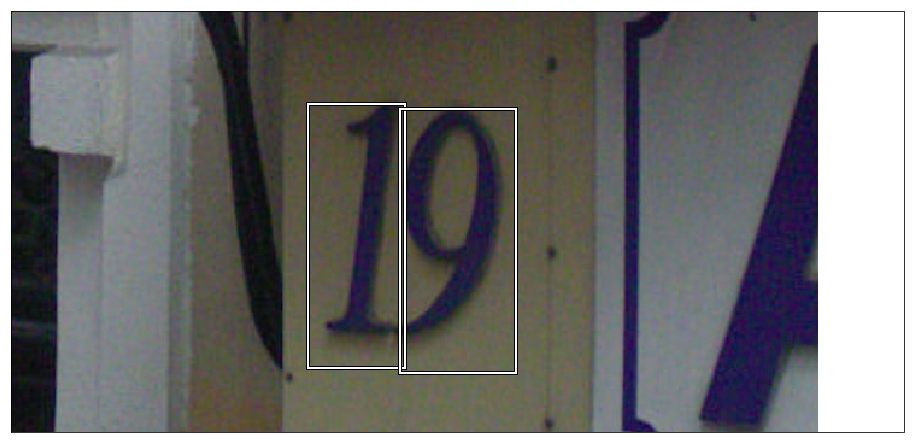

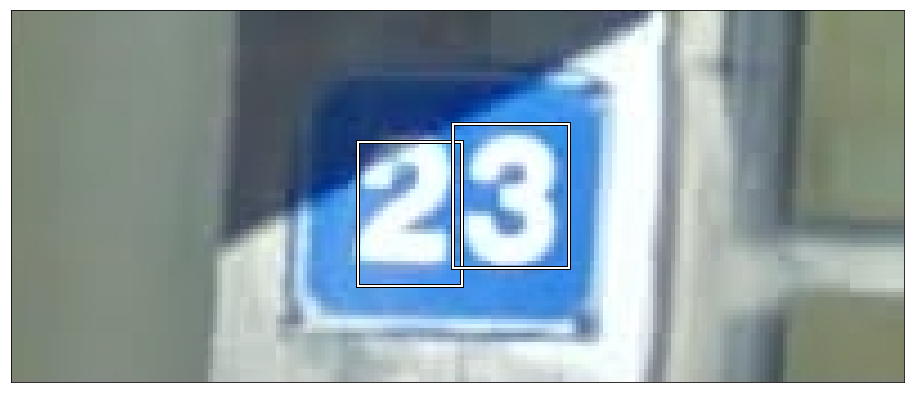

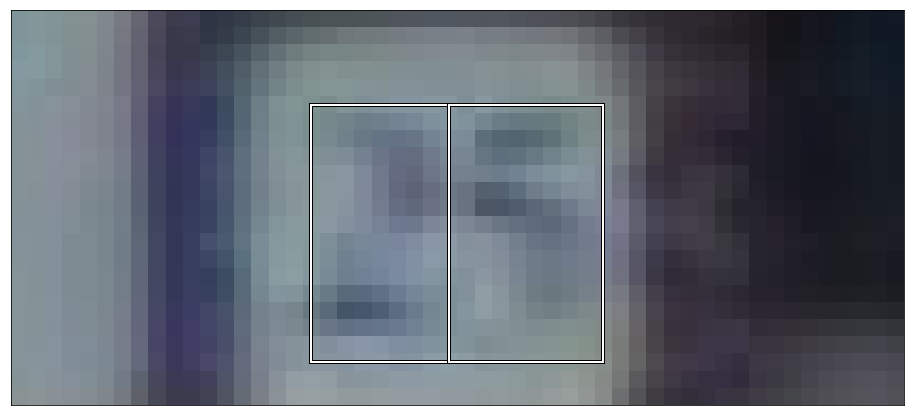

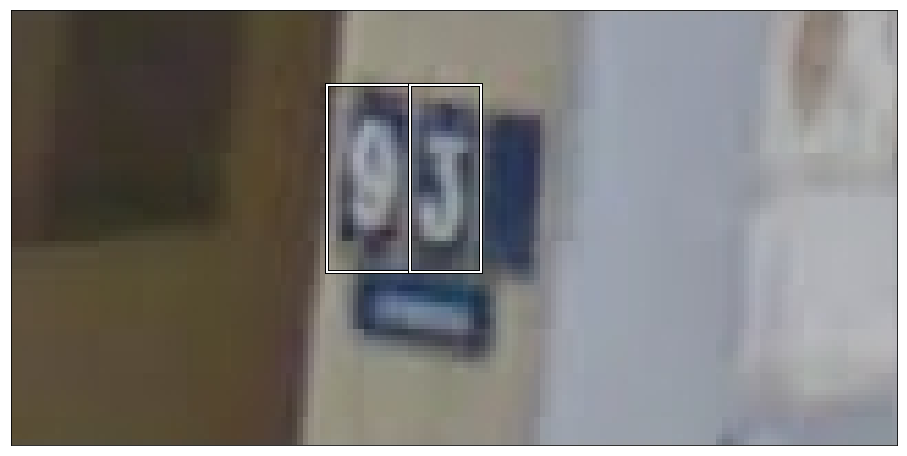

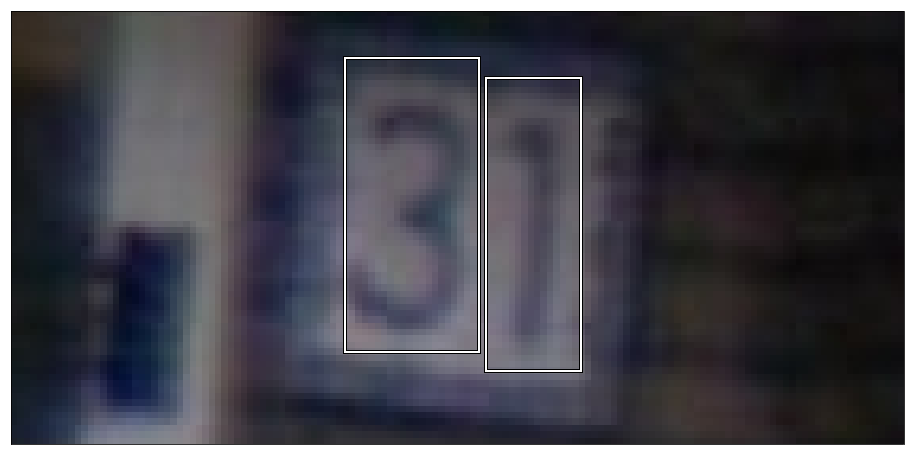

In [24]:
for i in range(1, 6):
    image = Image.open(train + str(i) + '.png')
    rectangle = box2rec(prepare_y(train_ydata[str(i) + '.png'])[0])
    draw_im(image, rectangle)    

## Prepare training and validation data

### Prepare X (run only first time)

In [70]:
train_Xdata = []
for _i in tqdm(range(1, train_size + 1)):
    im = Image.open(train + str(_i) + '.png')
    im_array = np.asarray(im)
    train_Xdata.append(im_array)
    im.load()



  0%|          | 0/33402 [00:00<?, ?it/s]

  0%|          | 137/33402 [00:00<00:24, 1352.35it/s]

  1%|          | 289/33402 [00:00<00:23, 1434.04it/s]

  1%|          | 411/33402 [00:00<00:24, 1344.04it/s]

  2%|▏         | 547/33402 [00:00<00:24, 1346.65it/s]

  2%|▏         | 712/33402 [00:00<00:23, 1407.03it/s]

  3%|▎         | 876/33402 [00:00<00:22, 1443.60it/s]

  3%|▎         | 1040/33402 [00:00<00:22, 1469.07it/s]

  4%|▎         | 1190/33402 [00:00<00:21, 1472.52it/s]

  4%|▍         | 1345/33402 [00:00<00:21, 1479.82it/s]

  5%|▍         | 1515/33402 [00:01<00:21, 1501.22it/s]

  5%|▍         | 1669/33402 [00:01<00:21, 1501.03it/s]

  5%|▌         | 1823/33402 [00:01<00:20, 1504.19it/s]

  6%|▌         | 1996/33402 [00:01<00:20, 1521.36it/s]

  6%|▋         | 2156/33402 [00:01<00:20, 1516.49it/s]

  7%|▋         | 2312/33402 [00:01<00:20, 1516.40it/s]

  7%|▋         | 2467/33402 [00:01<00:20, 1503.14it/s]

  8%|▊         | 2615/33402 [00:01<00:20, 1486.81it/s]

  8%|▊   

In [16]:
test_Xdata = []
for _i in tqdm(range(1, test_size + 1)):
    im = Image.open(test + str(_i) + '.png')
    im_array = np.asarray(im)
    test_Xdata.append(im_array)
    im.load()

100%|██████████| 13068/13068 [00:22<00:00, 569.00it/s]


In [72]:
np.save('data/train_Xdata.npy', train_Xdata) 

### Prepare images for neural net

In [25]:
def crop_image(im: Image, bb: list, new_width: int, new_height: int):
    width, height = im.size
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    im_c = im.crop((left, top, right, bottom))
    bb = [[ int(b[i] - left) if (i == 3) else b[i] for i in range(len(b))] for b in bb]
    return (im_c, bb)

In [26]:
def scale_image(im :Image, bb : list):
    width, height = im.size
    im = np.array(im)
    t_height, t_width = input_shape[:2]
    if width > height:
        factor = float(t_width/width)
        n_height = int(height * factor)        
        im = cv2.resize(im,(t_width, n_height));
        border_needed = t_height - n_height
        top_b, bot_b = (int(border_needed/2), int(border_needed/2))
        if border_needed % 2 != 0:
            top_b +=1
        im = cv2.copyMakeBorder(im, top_b, bot_b, 0, 0,cv2.BORDER_CONSTANT, value = [255, 255, 255])
        bb = [[int(b[i] * factor) + top_b if i == 1 else int(b[i] * factor) for i in range(len(b))]for b in bb]
    else:
        factor = float(t_height/height)
        n_width = int(width * factor)
        im = cv2.resize(im,(n_width, t_height));
        border_needed = t_width - n_width
        rb, lb = (int(border_needed/2), int(border_needed/2))
        if border_needed % 2 != 0:
            rb +=1
        im = cv2.copyMakeBorder(im, 0, 0, rb, lb,cv2.BORDER_CONSTANT, value = [255, 255, 255])
        bb = [[int(b[i] * factor) + lb if i == 3 else int(b[i] * factor) for i in range(len(b))]for b in bb]
    return (im, bb)

In [27]:
def prepare_image(im: Image, bb: list, cropping_factor: float):
    width, height = im.size[:2]
    if width * cropping_factor > height:
        im, bb = crop_image(im, bb, width * cropping_factor, height)
    elif height * cropping_factor > width: 
        im, bb = crop_image(im, bb, width, height * cropping_factor)
    im, bb = scale_image(im, bb)
    return (im, bb)

In [109]:
def prepare_xy(test_train: str, y_data: dict, batch_size: int):
    X = []
    yl = []
    yr = []
    for _i in tqdm(range(1, batch_size + 1)):
        im = Image.open(test_train + str(_i) + '.png')
        im.load()
        bb, label = prepare_y(y_data[str(_i) + '.png'])
        bb = box2rec(bb)
        im, bb = prepare_image(im, bb, 1/1.5)
        box = rec2box(bb)
        X.append(im)
        yl.append(box)
        yr.append(label)
    return (np.array(X), np.array(yl), np.array(yr))

## Model

Model plan

1. Use ResNet50 as a model for example
2. Modify it to contain less layers for speed
3. Modify it to have a pyramidical structure for speed (with MaxPooling)
4. Activation relu
5. Dropout for avoiding overfitting
6. Normalization?
7. Dense layer in the end to add non-linearity?
8. Use Square error loss or something similar as loss to bounding box loss
9. Use binary_crossentropy loss for categorial loss
10. Prepare some callout function that presents all the valuable information about the proceeding of training

Model(x, [out1, out2])
 
 
 Model.compile(optimizer='sgd', loss=['mean_squared_error
', 'binary_crossentropy'], metrics=['accuracy'], loss_weights=[1., 0.2])

model.fit(inputData,[outputYLeft, outputYRight], epochs=..., batch_size=...)

In [101]:
def conv_block(input_tensor, filter_size):
    x = Conv2D(filter_size, (3, 3), activation='relu')(input_tensor) # Why Conv2D?
    x = BatchNormalization(axis=3)(x) # Why important?
    x = Dropout(0.2)(x) # For avoiding overfitting
    x = MaxPooling2D((3,3), strides=(2,2))(x) # For loowering dimensionality
    return x

In [102]:
filter_size = [84, 56, 38, 26]
inp = Input(shape=input_shape)
zp = ZeroPadding2D((1,1),input_shape=input_shape)(inp) # Why important?
conv1 = conv_block(zp, filter_size[0])
conv2 = conv_block(conv1, filter_size[1])
conv3 = conv_block(conv2, filter_size[2])
conv4 = conv_block(conv3, filter_size[3])
flat = Flatten()(conv4) # Makes the data 1 dimensional
out1 = Dense(max_numbers * box_keys, activation='linear')(flat) # Output for box values
out2 = Dense(number_of_classes, activation='softmax')(flat) # Output for class information
model = Model(inp, [out1, out2])

In [103]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) # Often good with shallow networks
model.compile(optimizer=sgd, loss=['mean_squared_error', 'binary_crossentropy'], metrics=['accuracy'])

Other needs... 

1. Make function that tells which number is first (the one with lowest left value)
2. Prepare the number drawing function

## Test with 1000t and 200v images

In [68]:
train_ydata = np.load('data/train_ydict.npy').item()
test_ydata = np.load('data/test_ydict.npy').item()

In [69]:
train_batch = 1000
test_batch = 200

In [110]:
X_train, y_trainl, y_trainr = prepare_xy(train, train_ydata, train_batch)

100%|██████████| 1000/1000 [00:00<00:00, 1095.36it/s]


In [111]:
X_test, y_testl, y_testr = prepare_xy(test, test_ydata, test_batch)

100%|██████████| 200/200 [00:00<00:00, 668.94it/s]


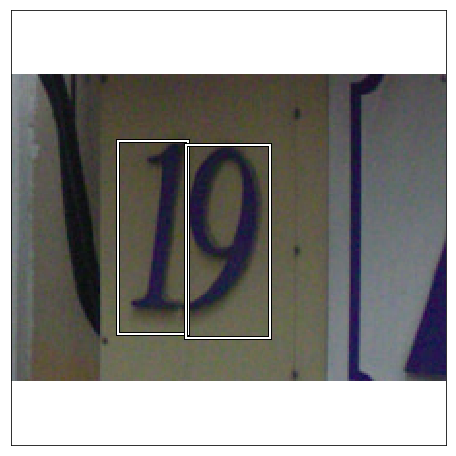

In [112]:
draw_im(X_train[0], box2rec(y_trainl[0]))

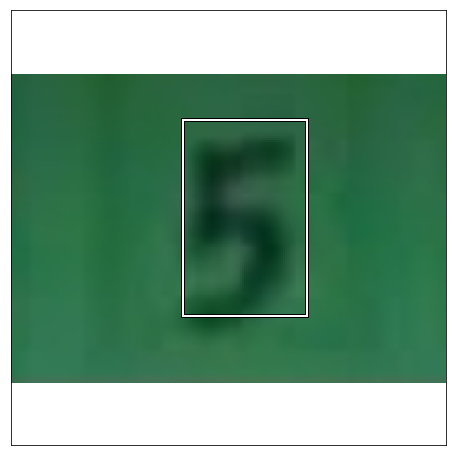

In [113]:
draw_im(X_test[0], box2rec(y_testl[0]))

In [114]:
model.fit(X_train,[y_trainl, y_trainr], epochs=5, batch_size=30, validation_data=(X_test, [y_testl, y_testr]), verbose=1)

Train on 1000 samples, validate on 200 samples
Epoch 1/5
1000/1000 [==============================] - 530s 530ms/step - loss: nan - dense_1_loss: nan - dense_2_loss: nan - dense_1_acc: 0.3770 - dense_2_acc: 0.1259 - val_loss: nan - val_dense_1_loss: nan - val_dense_2_loss: nan - val_dense_1_acc: 0.1250 - val_dense_2_acc: 0.0000e+00
Epoch 2/5
1000/1000 [==============================] - 527s 527ms/step - loss: nan - dense_1_loss: nan - dense_2_loss: nan - dense_1_acc: 0.4020 - dense_2_acc: 0.0000e+00 - val_loss: nan - val_dense_1_loss: nan - val_dense_2_loss: nan - val_dense_1_acc: 0.1250 - val_dense_2_acc: 0.0000e+00
Epoch 3/5
1000/1000 [==============================] - 529s 529ms/step - loss: nan - dense_1_loss: nan - dense_2_loss: nan - dense_1_acc: 0.4020 - dense_2_acc: 0.0000e+00 - val_loss: nan - val_dense_1_loss: nan - val_dense_2_loss: nan - val_dense_1_acc: 0.1250 - val_dense_2_acc: 0.0000e+00
Epoch 4/5
1000/1000 [==============================] - 529s 529ms/step - loss: nan -

In [115]:
model.fit(X_train,[y_trainl, y_trainr], epochs=5, batch_size=30, validation_data=(X_test, [y_testl, y_testr]), verbose=1)

Train on 1000 samples, validate on 200 samples
Epoch 1/5
1000/1000 [==============================] - 529s 529ms/step - loss: nan - dense_1_loss: nan - dense_2_loss: nan - dense_1_acc: 0.4020 - dense_2_acc: 0.0000e+00 - val_loss: nan - val_dense_1_loss: nan - val_dense_2_loss: nan - val_dense_1_acc: 0.1250 - val_dense_2_acc: 0.0000e+00
Epoch 2/5
1000/1000 [==============================] - 528s 528ms/step - loss: nan - dense_1_loss: nan - dense_2_loss: nan - dense_1_acc: 0.4020 - dense_2_acc: 0.0000e+00 - val_loss: nan - val_dense_1_loss: nan - val_dense_2_loss: nan - val_dense_1_acc: 0.1250 - val_dense_2_acc: 0.0000e+00
Epoch 3/5
1000/1000 [==============================] - 528s 528ms/step - loss: nan - dense_1_loss: nan - dense_2_loss: nan - dense_1_acc: 0.4020 - dense_2_acc: 0.0000e+00 - val_loss: nan - val_dense_1_loss: nan - val_dense_2_loss: nan - val_dense_1_acc: 0.1250 - val_dense_2_acc: 0.0000e+00
Epoch 4/5
1000/1000 [==============================] - 527s 527ms/step - loss: n